# Load Libraries and Resources

In [1]:
library('readr')
library('blabr')
library('plyr')
library('dplyr')
library('ggplot2')
library('rjson')
library('parallel')
library("readxl")
library('dotwhisker')
library('broom')
library('lme4')
library('irr')
library('tuneR')
library('ggExtra')
library('brms')
library('ggstance')
source('PLEARN_analysis_helper.R')
source('texvars.R')
tvc = initialize_texvar_cache()


Attaching package: ‘dplyr’


The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Matrix

Loading required package: lpSolve

Loading required package: Rcpp

Loading 'brms' package (version 2.17.0). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').


Attaching package: ‘brms’


The following object is masked from ‘package:lme4’:

    ngrps


The following object is masked from ‘package:stats’:

    ar



Attaching package: ‘ggstance’


The following objects are masked from ‘package:ggplot2’:

    geom_errorbarh, GeomErrorbarh




# Load Data Objects

In [2]:
subject_info = readRDS(file='intermediate_data/subject_info.RData')

# Load Item and Timing data

In [3]:
item_properties = read.csv('../PLEARN_experiments/csv/plearn_receptiveTask_datasource.csv')
item_properties$AudioTarget = sapply(item_properties$AudioTarget, trimws)
length(unique(item_properties$AudioTarget))
item_properties$AudioTarget[duplicated(item_properties$AudioTarget)] #64 test items + 4 practice

[1] 68

[1] "65.wav" "71.wav" "66.wav" "72.wav"

In [4]:
# audio timings for the version with the scene / background ("bg_")
bg_audio_timings = getAudioTimingsFromGlob("../PLEARN_experiments/stimuli/raw_audio2/*.cut")
bg_audio_timings_with_metadata = merge(item_properties, bg_audio_timings, by.x='AudioTarget', 
    by.y='audiotarget')
bg_audio_timings_with_metadata$plural_duration = (bg_audio_timings_with_metadata$target_noun_end_time -
    bg_audio_timings_with_metadata$begin_disambig_region) * 1000 
print(nrow(bg_audio_timings_with_metadata))

[1] 72


In [5]:
# audio timings for the simplified or red/blue version ("rb_")
rb_audio_timings = getAudioTimingsFromGlob("../PLEARN_experiments/stimuli/raw_audio_simplified/*.cut")
rb_audio_timings_with_metadata = merge(item_properties, rb_audio_timings, by.x='AudioTarget', 
    by.y='audiotarget') 
rb_audio_timings_with_metadata$plural_duration = (rb_audio_timings_with_metadata$target_noun_end_time -
    rb_audio_timings_with_metadata$begin_disambig_region) * 1000 
print(nrow(rb_audio_timings_with_metadata))

[1] 72


In [6]:
# Get audio timings for the agreement version in lookit
glob = "../PLEARN_experiments/stimuli/raw_audio_agreement2/s1-s72.cut"
json_paths = Sys.glob(glob)
lookit_agreement_audio_timings = data.frame(do.call('rbind', lapply(json_paths, function(path){
    as.data.frame(do.call('rbind', fromJSON(file = path)))
})))
for (colname in names(lookit_agreement_audio_timings)){ 
	    lookit_agreement_audio_timings[[colname]] = unlist(lookit_agreement_audio_timings[[colname]])
}
time_cols = setdiff(names(lookit_agreement_audio_timings), 'filename') 
for (colname in time_cols){ 
	    lookit_agreement_audio_timings[[colname]] = strptime(lookit_agreement_audio_timings[[colname]], format="%M:%OS")
}
# 2000 blank, 2500 with items onscreen, ~1100 with audio til is/are 
lookit_agreement_audio_timings$disambig_time = 2000+2500+(1000*(lookit_agreement_audio_timings$begin_disambig_region - lookit_agreement_audio_timings$start_time))
lookit_agreement_audio_timings$audiotarget = lookit_agreement_audio_timings$filename

In [7]:
# Get audio timings for the agreement version in the lab
glob = "../PLEARN_experiments/stimuli/raw_audio_agreement2/s1-s72.cut"
json_paths = Sys.glob(glob)
inlab_agreement_audio_timings = data.frame(do.call('rbind', lapply(json_paths, function(path){
    as.data.frame(do.call('rbind', fromJSON(file = path)))
})))
for (colname in names(inlab_agreement_audio_timings)){ 
	    inlab_agreement_audio_timings[[colname]] = unlist(inlab_agreement_audio_timings[[colname]])
}
time_cols = setdiff(names(inlab_agreement_audio_timings), 'filename') 
for (colname in time_cols){ 
	    inlab_agreement_audio_timings[[colname]] = strptime(inlab_agreement_audio_timings[[colname]], format="%M:%OS")
}
# 2000 blank, 2500 with items onscreen, ~1100 with audio til is/are 
inlab_agreement_audio_timings$disambig_time = 2000+ (1000*(inlab_agreement_audio_timings$begin_disambig_region - inlab_agreement_audio_timings$start_time))
inlab_agreement_audio_timings$audiotarget = inlab_agreement_audio_timings$filename

# Preprocess Eyetracking Data

In [8]:
subject_info$in_study = subject_info$type == 'adult' | subject_info$child_in_study

In [9]:
eyetracking_participants = subset(subject_info, expt_version 
    %in% c('agreement', 'scene','redblue') & include_eyetracking == 1)  
options(readr.show_col_types = FALSE)

ed = lapply(1:nrow(eyetracking_participants), function(i){
#ed = mclapply(1:nrow(eyetracking_participants), function(i){
    
    participant = eyetracking_participants[i,]
    if (!participant$in_study |
        participant$filename == '' | is.null(participant$filename) |
        is.na(participant$filename) | participant$include_eyetracking == 0){
        print(paste0('No eyetracking data for ', participant$id,' (or excluded), skipping...'))
        return(NULL)
    } else {
        if (participant$expt_version == 'scene'){
            audio_timings = bg_audio_timings
        } else if (participant$expt_version == 'redblue') {
            audio_timings = rb_audio_timings
         } else if (participant$expt_version == 'agreement') {
            audio_timings = inlab_agreement_audio_timings                
        } else {
            stop('expt_version not recognized')
        }        
        return(analyzeEyetrackingParticipant(
            'results/', 
            participant, 
            audio_timings,
        start_analysis_window = 1000,
        end_analysis_window = 1800))
    }
#}, mc.cores=48)
})

[1] "processing results/adultpl01_fixations.xlsx..."
[1] "Dimensions of excel file read in:"
[1] 451
[1] "will write to:"
[1] "results/adultpl01_fixations.txt"
[1] "Correct number of trials in the original data"
[1] "Correct number of trials in merging with audio timings"
[1] "Dims of gaze before binify"
[1] 408 269
[1] "Finished binning fixations"
[1] "Correct number of trials after binning procedure"
[1] "Correct number of trials after augmentation"
[1] "processing results/adultpl02_fixations.xlsx..."
[1] "Dimensions of excel file read in:"
[1] 591
[1] "will write to:"
[1] "results/adultpl02_fixations.txt"
[1] "Correct number of trials in the original data"
[1] "Correct number of trials in merging with audio timings"
[1] "Dims of gaze before binify"
[1] 536 269
[1] "Finished binning fixations"
[1] "Correct number of trials after binning procedure"
[1] "Correct number of trials after augmentation"
[1] "processing results/adultpl03_fixations.xlsx..."
[1] "Dimensions of excel file read 

New names:
• `__trial_index__1` -> `__trial_index__1...236`
• `__trial_index__1` -> `__trial_index__1...237`


[1] "Correct number of trials in the original data"
[1] "Correct number of trials in merging with audio timings"
[1] "Dims of gaze before binify"
[1] 683 270
[1] "Finished binning fixations"
[1] "Correct number of trials after binning procedure"
[1] "Correct number of trials after augmentation"
[1] "processing results/pl129_fixations.txt..."
[1] "Missing trials in the original data"
[1] "Correct number of trials in merging with audio timings"
[1] "Dims of gaze before binify"
[1] 484 269
[1] "Finished binning fixations"
[1] "Correct number of trials after binning procedure"
[1] "Correct number of trials after augmentation"
[1] "processing results/pl132_fixations.txt..."
[1] "Correct number of trials in the original data"
[1] "Correct number of trials in merging with audio timings"
[1] "Dims of gaze before binify"
[1] 596 269
[1] "Finished binning fixations"
[1] "Correct number of trials after binning procedure"
[1] "Correct number of trials after augmentation"
[1] "processing results/pl

New names:
• `__trial_index__1` -> `__trial_index__1...236`
• `__trial_index__1` -> `__trial_index__1...237`


[1] "Missing trials in the original data"
[1] "Correct number of trials in merging with audio timings"
[1] "Dims of gaze before binify"
[1] 554 270
[1] "Finished binning fixations"
[1] "Correct number of trials after binning procedure"
[1] "Correct number of trials after augmentation"
[1] "processing results/pl139_fixations.txt..."
[1] "Missing trials in the original data"
[1] "Correct number of trials in merging with audio timings"
[1] "Dims of gaze before binify"
[1] 450 269
[1] "Finished binning fixations"
[1] "Correct number of trials after binning procedure"
[1] "Correct number of trials after augmentation"
[1] "processing results/pl14_fixations.xlsx..."


New names:
• `__trial_index__1` -> `__trial_index__1...236`
• `__trial_index__1` -> `__trial_index__1...237`
• `__trial_index__1` -> `__trial_index__1...238`
• `__trial_index__1` -> `__trial_index__1...239`


[1] "Dimensions of excel file read in:"
[1] 520
[1] "will write to:"
[1] "results/pl14_fixations.txt"
[1] "Correct number of trials in the original data"
[1] "Correct number of trials in merging with audio timings"
[1] "Dims of gaze before binify"
[1] 477 272
[1] "Finished binning fixations"
[1] "Correct number of trials after binning procedure"
[1] "Correct number of trials after augmentation"
[1] "processing results/pl140_fixations.txt..."
[1] "Correct number of trials in the original data"
[1] "Correct number of trials in merging with audio timings"
[1] "Dims of gaze before binify"
[1] 488 269
[1] "Finished binning fixations"
[1] "Correct number of trials after binning procedure"
[1] "Correct number of trials after augmentation"
[1] "processing results/pl141_fixations.txt..."
[1] "Correct number of trials in the original data"
[1] "Correct number of trials in merging with audio timings"
[1] "Dims of gaze before binify"
[1] 479 269
[1] "Finished binning fixations"
[1] "Correct number

New names:
• `__trial_index__1` -> `__trial_index__1...236`
• `__trial_index__1` -> `__trial_index__1...237`
• `__trial_index__1` -> `__trial_index__1...238`
• `__trial_index__1` -> `__trial_index__1...239`


[1] "Dimensions of excel file read in:"
[1] 725
[1] "will write to:"
[1] "results/pl15_fixations.txt"
[1] "Correct number of trials in the original data"
[1] "Correct number of trials in merging with audio timings"
[1] "Dims of gaze before binify"
[1] 676 272
[1] "Finished binning fixations"
[1] "Correct number of trials after binning procedure"
[1] "Correct number of trials after augmentation"
[1] "processing results/pl150_fixations.txt..."
[1] "Missing trials in the original data"
[1] "Correct number of trials in merging with audio timings"
[1] "Dims of gaze before binify"
[1] 474 269
[1] "Finished binning fixations"
[1] "Correct number of trials after binning procedure"
[1] "Correct number of trials after augmentation"
[1] "processing results/pl152_fixations.txt..."
[1] "Missing trials in the original data"
[1] "Correct number of trials in merging with audio timings"
[1] "Dims of gaze before binify"
[1] 437 269
[1] "Finished binning fixations"
[1] "Correct number of trials after bin

New names:
• `__trial_index__1` -> `__trial_index__1...236`
• `__trial_index__1` -> `__trial_index__1...237`
• `__trial_index__1` -> `__trial_index__1...238`
• `__trial_index__1` -> `__trial_index__1...239`


[1] "Dimensions of excel file read in:"
[1] 681
[1] "will write to:"
[1] "results/pl16_fixations.txt"
[1] "Correct number of trials in the original data"
[1] "Correct number of trials in merging with audio timings"
[1] "Dims of gaze before binify"
[1] 617 272
[1] "Finished binning fixations"
[1] "Correct number of trials after binning procedure"
[1] "Correct number of trials after augmentation"
[1] "processing results/pl18_fixations.xlsx..."


New names:
• `__trial_index__1` -> `__trial_index__1...236`
• `__trial_index__1` -> `__trial_index__1...237`
• `__trial_index__1` -> `__trial_index__1...238`


[1] "Dimensions of excel file read in:"
[1] 748
[1] "will write to:"
[1] "results/pl18_fixations.txt"
[1] "Correct number of trials in the original data"
[1] "Correct number of trials in merging with audio timings"
[1] "Dims of gaze before binify"
[1] 672 271
[1] "Finished binning fixations"
[1] "Correct number of trials after binning procedure"
[1] "Correct number of trials after augmentation"
[1] "processing results/pl19_fixations.xlsx..."


New names:
• `__trial_index__1` -> `__trial_index__1...236`
• `__trial_index__1` -> `__trial_index__1...237`
• `__trial_index__1` -> `__trial_index__1...238`


[1] "Dimensions of excel file read in:"
[1] 546
[1] "will write to:"
[1] "results/pl19_fixations.txt"
[1] "Correct number of trials in the original data"
[1] "Correct number of trials in merging with audio timings"
[1] "Dims of gaze before binify"
[1] 505 271
[1] "Finished binning fixations"
[1] "Correct number of trials after binning procedure"
[1] "Correct number of trials after augmentation"
[1] "processing results/pl20_fixations.xlsx..."


New names:
• `__trial_index__1` -> `__trial_index__1...236`
• `__trial_index__1` -> `__trial_index__1...237`
• `__trial_index__1` -> `__trial_index__1...238`
• `__trial_index__1` -> `__trial_index__1...239`
• `__trial_index__1` -> `__trial_index__1...240`


[1] "Dimensions of excel file read in:"
[1] 735
[1] "will write to:"
[1] "results/pl20_fixations.txt"
[1] "Correct number of trials in the original data"
[1] "Correct number of trials in merging with audio timings"
[1] "Dims of gaze before binify"
[1] 693 273
[1] "Finished binning fixations"
[1] "Correct number of trials after binning procedure"
[1] "Correct number of trials after augmentation"
[1] "processing results/pl24_fixations.xlsx..."


New names:
• `__trial_index__1` -> `__trial_index__1...236`
• `__trial_index__1` -> `__trial_index__1...237`
• `__trial_index__1` -> `__trial_index__1...238`
• `__trial_index__1` -> `__trial_index__1...239`
• `__trial_index__1` -> `__trial_index__1...240`


[1] "Dimensions of excel file read in:"
[1] 703
[1] "will write to:"
[1] "results/pl24_fixations.txt"
[1] "Correct number of trials in the original data"
[1] "Correct number of trials in merging with audio timings"
[1] "Dims of gaze before binify"
[1] 645 273
[1] "Finished binning fixations"
[1] "Correct number of trials after binning procedure"
[1] "Correct number of trials after augmentation"
[1] "processing results/pl25_fixations.xlsx..."


New names:
• `__trial_index__1` -> `__trial_index__1...236`
• `__trial_index__1` -> `__trial_index__1...237`
• `__trial_index__1` -> `__trial_index__1...238`
• `__trial_index__1` -> `__trial_index__1...239`
• `__trial_index__1` -> `__trial_index__1...240`


[1] "Dimensions of excel file read in:"
[1] 545
[1] "will write to:"
[1] "results/pl25_fixations.txt"
[1] "Correct number of trials in the original data"
[1] "Correct number of trials in merging with audio timings"
[1] "Dims of gaze before binify"
[1] 499 273
[1] "Finished binning fixations"
[1] "Lost trials in binning procedure"
[1] "Lost trials in augmentation"
[1] "processing results/pl28_fixations.xlsx..."
[1] "Dimensions of excel file read in:"
[1] 604
[1] "will write to:"
[1] "results/pl28_fixations.txt"
[1] "Correct number of trials in the original data"
[1] "Correct number of trials in merging with audio timings"
[1] "Dims of gaze before binify"
[1] 551 269
[1] "Finished binning fixations"
[1] "Correct number of trials after binning procedure"
[1] "Correct number of trials after augmentation"
[1] "processing results/pl29_fixations.xlsx..."
[1] "Dimensions of excel file read in:"
[1] 700
[1] "will write to:"
[1] "results/pl29_fixations.txt"
[1] "Correct number of trials in the o

New names:
• `__trial_index__1` -> `__trial_index__1...236`
• `__trial_index__1` -> `__trial_index__1...237`
• `__trial_index__1` -> `__trial_index__1...238`
• `__trial_index__1` -> `__trial_index__1...239`
• `__trial_index__1` -> `__trial_index__1...240`
• `__trial_index__1` -> `__trial_index__1...241`
• `__trial_index__1` -> `__trial_index__1...242`
• `__trial_index__1` -> `__trial_index__1...243`
• `__trial_index__1` -> `__trial_index__1...244`
• `__trial_index__1` -> `__trial_index__1...245`


[1] "Dimensions of excel file read in:"
[1] 597
[1] "will write to:"
[1] "results/pl46_fixations.txt"
[1] "Correct number of trials in the original data"
[1] "Correct number of trials in merging with audio timings"
[1] "Dims of gaze before binify"
[1] 552 278
[1] "Finished binning fixations"
[1] "Correct number of trials after binning procedure"
[1] "Correct number of trials after augmentation"
[1] "processing results/pl47_fixations.xlsx..."


New names:
• `__trial_index__1` -> `__trial_index__1...236`
• `__trial_index__1` -> `__trial_index__1...237`
• `__trial_index__1` -> `__trial_index__1...238`
• `__trial_index__1` -> `__trial_index__1...239`
• `__trial_index__1` -> `__trial_index__1...240`
• `__trial_index__1` -> `__trial_index__1...241`
• `__trial_index__1` -> `__trial_index__1...242`
• `__trial_index__1` -> `__trial_index__1...243`
• `__trial_index__1` -> `__trial_index__1...244`
• `__trial_index__1` -> `__trial_index__1...245`


[1] "Dimensions of excel file read in:"
[1] 721
[1] "will write to:"
[1] "results/pl47_fixations.txt"
[1] "Correct number of trials in the original data"
[1] "Correct number of trials in merging with audio timings"
[1] "Dims of gaze before binify"
[1] 680 278
[1] "Finished binning fixations"
[1] "Correct number of trials after binning procedure"
[1] "Correct number of trials after augmentation"
[1] "processing results/pl48_fixations.xlsx..."


New names:
• `__trial_index__1` -> `__trial_index__1...236`
• `__trial_index__1` -> `__trial_index__1...237`
• `__trial_index__1` -> `__trial_index__1...238`
• `__trial_index__1` -> `__trial_index__1...239`
• `__trial_index__1` -> `__trial_index__1...240`
• `__trial_index__1` -> `__trial_index__1...241`
• `__trial_index__1` -> `__trial_index__1...242`
• `__trial_index__1` -> `__trial_index__1...243`
• `__trial_index__1` -> `__trial_index__1...244`
• `__trial_index__1` -> `__trial_index__1...245`


[1] "Dimensions of excel file read in:"
[1] 619
[1] "will write to:"
[1] "results/pl48_fixations.txt"
[1] "Correct number of trials in the original data"
[1] "Correct number of trials in merging with audio timings"
[1] "Dims of gaze before binify"
[1] 569 278
[1] "Finished binning fixations"
[1] "Correct number of trials after binning procedure"
[1] "Correct number of trials after augmentation"
[1] "processing results/pl49_fixations.xlsx..."


New names:
• `__trial_index__1` -> `__trial_index__1...236`
• `__trial_index__1` -> `__trial_index__1...237`
• `__trial_index__1` -> `__trial_index__1...238`
• `__trial_index__1` -> `__trial_index__1...239`
• `__trial_index__1` -> `__trial_index__1...240`
• `__trial_index__1` -> `__trial_index__1...241`
• `__trial_index__1` -> `__trial_index__1...242`
• `__trial_index__1` -> `__trial_index__1...243`
• `__trial_index__1` -> `__trial_index__1...244`
• `__trial_index__1` -> `__trial_index__1...245`


[1] "Dimensions of excel file read in:"
[1] 514
[1] "will write to:"
[1] "results/pl49_fixations.txt"
[1] "Missing trials in the original data"
[1] "Correct number of trials in merging with audio timings"
[1] "Dims of gaze before binify"
[1] 471 278
[1] "Finished binning fixations"
[1] "Lost trials in binning procedure"
[1] "Lost trials in augmentation"
[1] "processing results/pl50_fixations.xlsx..."


New names:
• `__trial_index__1` -> `__trial_index__1...236`
• `__trial_index__1` -> `__trial_index__1...237`
• `__trial_index__1` -> `__trial_index__1...238`
• `__trial_index__1` -> `__trial_index__1...239`
• `__trial_index__1` -> `__trial_index__1...240`
• `__trial_index__1` -> `__trial_index__1...241`
• `__trial_index__1` -> `__trial_index__1...242`
• `__trial_index__1` -> `__trial_index__1...243`
• `__trial_index__1` -> `__trial_index__1...244`
• `__trial_index__1` -> `__trial_index__1...245`


[1] "Dimensions of excel file read in:"
[1] 569
[1] "will write to:"
[1] "results/pl50_fixations.txt"
[1] "Correct number of trials in the original data"
[1] "Correct number of trials in merging with audio timings"
[1] "Dims of gaze before binify"
[1] 531 278
[1] "Finished binning fixations"
[1] "Lost trials in binning procedure"
[1] "Lost trials in augmentation"
[1] "processing results/pl51_fixations.xlsx..."


New names:
• `__trial_index__1` -> `__trial_index__1...236`
• `__trial_index__1` -> `__trial_index__1...237`
• `__trial_index__1` -> `__trial_index__1...238`
• `__trial_index__1` -> `__trial_index__1...239`
• `__trial_index__1` -> `__trial_index__1...240`
• `__trial_index__1` -> `__trial_index__1...241`
• `__trial_index__1` -> `__trial_index__1...242`
• `__trial_index__1` -> `__trial_index__1...243`
• `__trial_index__1` -> `__trial_index__1...244`
• `__trial_index__1` -> `__trial_index__1...245`


[1] "Dimensions of excel file read in:"
[1] 718
[1] "will write to:"
[1] "results/pl51_fixations.txt"
[1] "Correct number of trials in the original data"
[1] "Correct number of trials in merging with audio timings"
[1] "Dims of gaze before binify"
[1] 686 278
[1] "Finished binning fixations"
[1] "Correct number of trials after binning procedure"
[1] "Correct number of trials after augmentation"
[1] "processing results/pl52_fixations.xlsx..."


New names:
• `__trial_index__1` -> `__trial_index__1...236`
• `__trial_index__1` -> `__trial_index__1...237`
• `__trial_index__1` -> `__trial_index__1...238`
• `__trial_index__1` -> `__trial_index__1...239`
• `__trial_index__1` -> `__trial_index__1...240`
• `__trial_index__1` -> `__trial_index__1...241`
• `__trial_index__1` -> `__trial_index__1...242`
• `__trial_index__1` -> `__trial_index__1...243`
• `__trial_index__1` -> `__trial_index__1...244`
• `__trial_index__1` -> `__trial_index__1...245`


[1] "Dimensions of excel file read in:"
[1] 579
[1] "will write to:"
[1] "results/pl52_fixations.txt"
[1] "Correct number of trials in the original data"
[1] "Correct number of trials in merging with audio timings"
[1] "Dims of gaze before binify"
[1] 542 278
[1] "Finished binning fixations"
[1] "Lost trials in binning procedure"
[1] "Lost trials in augmentation"
[1] "processing results/pl55_fixations.xlsx..."


New names:
• `__trial_index__1` -> `__trial_index__1...236`
• `__trial_index__1` -> `__trial_index__1...237`
• `__trial_index__1` -> `__trial_index__1...238`
• `__trial_index__1` -> `__trial_index__1...239`
• `__trial_index__1` -> `__trial_index__1...240`
• `__trial_index__1` -> `__trial_index__1...241`
• `__trial_index__1` -> `__trial_index__1...242`
• `__trial_index__1` -> `__trial_index__1...243`
• `__trial_index__1` -> `__trial_index__1...244`
• `__trial_index__1` -> `__trial_index__1...245`


[1] "Dimensions of excel file read in:"
[1] 671
[1] "will write to:"
[1] "results/pl55_fixations.txt"
[1] "Correct number of trials in the original data"
[1] "Correct number of trials in merging with audio timings"
[1] "Dims of gaze before binify"
[1] 637 278
[1] "Finished binning fixations"
[1] "Correct number of trials after binning procedure"
[1] "Correct number of trials after augmentation"
[1] "processing results/pl57_fixations.xlsx..."


New names:
• `__trial_index__1` -> `__trial_index__1...236`
• `__trial_index__1` -> `__trial_index__1...237`
• `__trial_index__1` -> `__trial_index__1...238`
• `__trial_index__1` -> `__trial_index__1...239`
• `__trial_index__1` -> `__trial_index__1...240`
• `__trial_index__1` -> `__trial_index__1...241`
• `__trial_index__1` -> `__trial_index__1...242`
• `__trial_index__1` -> `__trial_index__1...243`
• `__trial_index__1` -> `__trial_index__1...244`
• `__trial_index__1` -> `__trial_index__1...245`


[1] "Dimensions of excel file read in:"
[1] 515
[1] "will write to:"
[1] "results/pl57_fixations.txt"
[1] "Correct number of trials in the original data"
[1] "Correct number of trials in merging with audio timings"
[1] "Dims of gaze before binify"
[1] 469 278
[1] "Finished binning fixations"
[1] "Correct number of trials after binning procedure"
[1] "Correct number of trials after augmentation"
[1] "processing results/pl59_fixations.xlsx..."


New names:
• `__trial_index__1` -> `__trial_index__1...236`
• `__trial_index__1` -> `__trial_index__1...237`
• `__trial_index__1` -> `__trial_index__1...238`
• `__trial_index__1` -> `__trial_index__1...239`


[1] "Dimensions of excel file read in:"
[1] 678
[1] "will write to:"
[1] "results/pl59_fixations.txt"
[1] "Correct number of trials in the original data"
[1] "Correct number of trials in merging with audio timings"
[1] "Dims of gaze before binify"
[1] 633 272
[1] "Finished binning fixations"
[1] "Correct number of trials after binning procedure"
[1] "Correct number of trials after augmentation"
[1] "processing results/pl63_fixations.xlsx..."


New names:
• `__trial_index__1` -> `__trial_index__1...236`
• `__trial_index__1` -> `__trial_index__1...237`
• `__trial_index__1` -> `__trial_index__1...238`


[1] "Dimensions of excel file read in:"
[1] 833
[1] "will write to:"
[1] "results/pl63_fixations.txt"
[1] "Correct number of trials in the original data"
[1] "Correct number of trials in merging with audio timings"
[1] "Dims of gaze before binify"
[1] 776 271
[1] "Finished binning fixations"
[1] "Correct number of trials after binning procedure"
[1] "Correct number of trials after augmentation"
[1] "processing results/pl64_fixations.xlsx..."


New names:
• `__trial_index__1` -> `__trial_index__1...236`
• `__trial_index__1` -> `__trial_index__1...237`
• `__trial_index__1` -> `__trial_index__1...238`


[1] "Dimensions of excel file read in:"
[1] 629
[1] "will write to:"
[1] "results/pl64_fixations.txt"
[1] "Correct number of trials in the original data"
[1] "Correct number of trials in merging with audio timings"
[1] "Dims of gaze before binify"
[1] 582 271
[1] "Finished binning fixations"
[1] "Correct number of trials after binning procedure"
[1] "Correct number of trials after augmentation"
[1] "processing results/pl66_fixations.xlsx..."


New names:
• `__trial_index__1` -> `__trial_index__1...236`
• `__trial_index__1` -> `__trial_index__1...237`
• `__trial_index__1` -> `__trial_index__1...238`
• `__trial_index__1` -> `__trial_index__1...239`


[1] "Dimensions of excel file read in:"
[1] 718
[1] "will write to:"
[1] "results/pl66_fixations.txt"
[1] "Correct number of trials in the original data"
[1] "Correct number of trials in merging with audio timings"
[1] "Dims of gaze before binify"
[1] 634 272
[1] "Finished binning fixations"
[1] "Correct number of trials after binning procedure"
[1] "Correct number of trials after augmentation"
[1] "processing results/pl67_fixations.xlsx..."


New names:
• `__trial_index__1` -> `__trial_index__1...236`
• `__trial_index__1` -> `__trial_index__1...237`
• `__trial_index__1` -> `__trial_index__1...238`


[1] "Dimensions of excel file read in:"
[1] 668
[1] "will write to:"
[1] "results/pl67_fixations.txt"
[1] "Correct number of trials in the original data"
[1] "Correct number of trials in merging with audio timings"
[1] "Dims of gaze before binify"
[1] 612 271
[1] "Finished binning fixations"
[1] "Correct number of trials after binning procedure"
[1] "Correct number of trials after augmentation"
[1] "processing results/pl68_fixations.txt..."
[1] "Correct number of trials in the original data"
[1] "Correct number of trials in merging with audio timings"
[1] "Dims of gaze before binify"
[1] 467 280
[1] "Finished binning fixations"
[1] "Correct number of trials after binning procedure"
[1] "Correct number of trials after augmentation"
[1] "processing results/pl69_fixations.txt..."
[1] "Correct number of trials in the original data"
[1] "Correct number of trials in merging with audio timings"
[1] "Dims of gaze before binify"
[1] 554 280
[1] "Finished binning fixations"
[1] "Correct number o

In [10]:
ed_df = do.call('rbind.fill', ed)
ed_df$session_id = ed_df$filename

In [11]:
lookit_participants = subset(subject_info, expt_version 
                                 %in% c('agreement-lookit') & include_eyetracking == 1)

#ed_lookit = lapply(1:nrow(lookit_participants), function(i){
ed_lookit = mclapply(1:nrow(lookit_participants), function(i){
        participant = lookit_participants[i,]
        return(analyzeLookItParticipant(
            '/home/stephan/dropbox/Documents/MIT/research/PLEARN/lookit_data/', 
            participant$id, 
            trimws(strsplit(participant$main_coder,',')[[1]][1]),
            item_properties,
            lookit_agreement_audio_timings, 
            halt_on_missing=F,
            target_order = participant$trial_order,
            participant_type = 'child',
            plot=F,
            legacy = participant$id %in% c('jonahpilotlegacy')))
#    })
}, mc.cores=24)
ed_lookit_df = do.call('rbind.fill', ed_lookit)
ed_lookit_df$type = 'child'
ed_lookit_df$expt_version = "agreement-lookit"

In [12]:
ed_df_combined = rbind.fill(ed_df, ed_lookit_df)

In [13]:
nrow(ed_df_combined)

[1] 1871613

In [14]:
if (length(unique(subset(ed_df_combined, type == 'child')$session_id)) !=
    nrow(subset(subject_info, type == 'child' & include_eyetracking))){
    stop('Missing child data')
}

# Merge in the Production Scores

In [15]:
# re-associate subject info with each of the fixation reports
ed_df = merge(ed_df_combined, subject_info, by=c('filename', 'expt_version','type'))
nrow(ed_df)
names(ed_df)

[1] 1871613

[1] "filename"                        "expt_version"                   
  [3] "type"                            "expt_index"                     
  [5] "timeBin"                         "FixationID"                     
  [7] "CURRENT_FIX_START"               "CURRENT_FIX_END"                
  [9] "TRIAL_INDEX"                     "CURRENT_FIX_INDEX"              
 [11] "RECORDING_SESSION_LABEL"         "CURRENT_FIX_INTEREST_AREA_LABEL"
 [13] "RT"                              "target"                         
 [15] "s_form"                          "novelty"                        
 [17] "animacystatus"                   "voicing"                        
 [19] "practice"                        "Time"                           
 [21] "Nonset"                          "looks_to_t"                     
 [23] "looks_to_d"                      "looks_to_td"                    
 [25] "exclude_trial"                   "exclude_subject"                
 [27] "label_at_onset"                  "time_to_last_nonna"             
 [29] "track_loss_at_0"                 "session_id"                     
 [31] "AudioTarget"                     "ms"                             
 [33] "original_frame_index"            "frame_index"                    
 [35] "label"                           "trial"                          
 [37] "start_time_ms"                   "normalized_ms"                  
 [39] "frame_id"                        "seconds_recording_before_stim"  
 [41] "order.x"                         "normal_or_calibration"          
 [43] "novel_id"                        "background_context"             
 [45] "vowel_carrier"                   "full_carrier"                   
 [47] "s_carrier"                       "s_punct"                        
 [49] "s_wav_index"                     "s_sentence"                     
 [51] "pl_form"                         "pl_carrier"                     
 [53] "pl_punct"                        "pl_wav_index"                   
 [55] "pl_sentence"                     "simple_pl_stim"                 
 [57] "simple_s_stim"                   "animacyStatus"                  
 [59] "Trial"                           "Practice"                       
 [61] "test_index"                      "TargetSide"                     
 [63] "trial_index"                     "NovelColor"                     
 [65] "order.y"                         "TargetLoc"                      
 [67] "DistractorLoc"                   "TargetImage"                    
 [69] "DistractorImage"                 "disambig_time"                  
 [71] "TimeBin"                         "cfial_bin"                      
 [73] "index"                           "participant_name"               
 [75] "narrow_score"                    "broad_score"                    
 [77] "id"                              "include_eyetracking"            
 [79] "include_storybook"               "age_in_days"                    
 [81] "gender"                          "group"                          
 [83] "order"                           "comment"                        
 [85] "main_coder"                      "main_validated"                 
 [87] "double_coder"                    "double_validated"               
 [89] "comments"                        "trial_order"                    
 [91] "age_in_months"                   "ran_participant"                
 [93] "child_in_study"                  "fam_pl.x"                       
 [95] "nov_pl.x"                        "total_pl.x"                     
 [97] "fam_pl.y"                        "nov_pl.y"                       
 [99] "total_pl.y"                      "in_study"

# Automated Exclusions

In [16]:
names(ed_df)

[1] "filename"                        "expt_version"                   
  [3] "type"                            "expt_index"                     
  [5] "timeBin"                         "FixationID"                     
  [7] "CURRENT_FIX_START"               "CURRENT_FIX_END"                
  [9] "TRIAL_INDEX"                     "CURRENT_FIX_INDEX"              
 [11] "RECORDING_SESSION_LABEL"         "CURRENT_FIX_INTEREST_AREA_LABEL"
 [13] "RT"                              "target"                         
 [15] "s_form"                          "novelty"                        
 [17] "animacystatus"                   "voicing"                        
 [19] "practice"                        "Time"                           
 [21] "Nonset"                          "looks_to_t"                     
 [23] "looks_to_d"                      "looks_to_td"                    
 [25] "exclude_trial"                   "exclude_subject"                
 [27] "label_at_onset"                  "time_to_last_nonna"             
 [29] "track_loss_at_0"                 "session_id"                     
 [31] "AudioTarget"                     "ms"                             
 [33] "original_frame_index"            "frame_index"                    
 [35] "label"                           "trial"                          
 [37] "start_time_ms"                   "normalized_ms"                  
 [39] "frame_id"                        "seconds_recording_before_stim"  
 [41] "order.x"                         "normal_or_calibration"          
 [43] "novel_id"                        "background_context"             
 [45] "vowel_carrier"                   "full_carrier"                   
 [47] "s_carrier"                       "s_punct"                        
 [49] "s_wav_index"                     "s_sentence"                     
 [51] "pl_form"                         "pl_carrier"                     
 [53] "pl_punct"                        "pl_wav_index"                   
 [55] "pl_sentence"                     "simple_pl_stim"                 
 [57] "simple_s_stim"                   "animacyStatus"                  
 [59] "Trial"                           "Practice"                       
 [61] "test_index"                      "TargetSide"                     
 [63] "trial_index"                     "NovelColor"                     
 [65] "order.y"                         "TargetLoc"                      
 [67] "DistractorLoc"                   "TargetImage"                    
 [69] "DistractorImage"                 "disambig_time"                  
 [71] "TimeBin"                         "cfial_bin"                      
 [73] "index"                           "participant_name"               
 [75] "narrow_score"                    "broad_score"                    
 [77] "id"                              "include_eyetracking"            
 [79] "include_storybook"               "age_in_days"                    
 [81] "gender"                          "group"                          
 [83] "order"                           "comment"                        
 [85] "main_coder"                      "main_validated"                 
 [87] "double_coder"                    "double_validated"               
 [89] "comments"                        "trial_order"                    
 [91] "age_in_months"                   "ran_participant"                
 [93] "child_in_study"                  "fam_pl.x"                       
 [95] "nov_pl.x"                        "total_pl.x"                     
 [97] "fam_pl.y"                        "nov_pl.y"                       
 [99] "total_pl.y"                      "in_study"

In [17]:
# participants before exclusion
num_eyetracking_participants = aggregate(session_id ~ expt_version + type, 
    subset(ed_df, child_in_study), function(x){length(unique(x))} )
print(num_eyetracking_participants)

  expt_version  type session_id
1    agreement child         38
2      redblue child         37
3        scene child         34


In [18]:
# participants after exclusion
num_eyetracking_participants_after_exclusion =  aggregate(participant_name ~ expt_version + type, 
          subset(ed_df, child_in_study & exclude_subject == F), function(x){length(unique(x))} )
print(num_eyetracking_participants_after_exclusion)

  expt_version  type participant_name
1    agreement child               36
2      redblue child               36
3        scene child               34


In [19]:
# whole participants who were excluded
nChildrenWithExcludedTrials = 
length(unique(subset(ed_df, child_in_study & exclude_trial == T & !(exclude_subject) )$participant_name))
nChildrenWithExcludedTrials
tvc = update_texvar_cache(tvc, 'nChildrenWithExcludedTrials', 
    nChildrenWithExcludedTrials)

[1] 103

In [20]:
ed_df$name_trial = paste0(ed_df$participant_name,'_',ed_df$expt_index)

In [21]:
# whole participants who were excluded
nTrialsExcludedByFilter = 
length(unique(subset(ed_df, child_in_study & exclude_trial == T & !(exclude_subject))$name_trial))
nTrialsExcludedByFilter
tvc = update_texvar_cache(tvc, 'nTrialsExcludedByFilter', 
    nTrialsExcludedByFilter)

[1] 621

In [22]:
percentExcludedEyetrackingTrials = 100 * length(unique(
    subset(ed_df, child_in_study & exclude_trial == T & !(exclude_subject))$name_trial)) / length(unique(subset(ed_df, child_in_study &  !(exclude_subject))$name_trial))
percentExcludedEyetrackingTrials
tvc = update_texvar_cache(tvc, 'percentExcludedEyetrackingTrials', 
    percentExcludedEyetrackingTrials, digits=0)

[1] 18.90411

In [23]:
# whole participants who were excluded
n_eyetracking_subj_excluded_by_data_filter = length(unique(subset(ed_df, child_in_study & exclude_subject ==T )$participant_name))
n_eyetracking_subj_excluded_by_data_filter
tvc = update_texvar_cache(tvc, 'nEyetrackingSubjExcludedByDataFilter', 
    n_eyetracking_subj_excluded_by_data_filter)
writeout_texvar_cache(tvc, 'texvars/plearn_analysis.tex',appendDate=T)

[1] 3

# Add the trial order as a grouping variable

In [24]:
ed_df$first3 = 'remainder'
ed_df$first3[ed_df$TRIAL_INDEX <= 7] = 'first 3 test trials'
ed_df$first3[ed_df$TRIAL_INDEX <= 4] = 'training trials'

# Trial Exclusion Rate over the Course of the Experiments

In [25]:
num_trials_per_subj = aggregate(TRIAL_INDEX ~ participant_name + exclude_trial, ed_df, function(x){length(unique(x))})

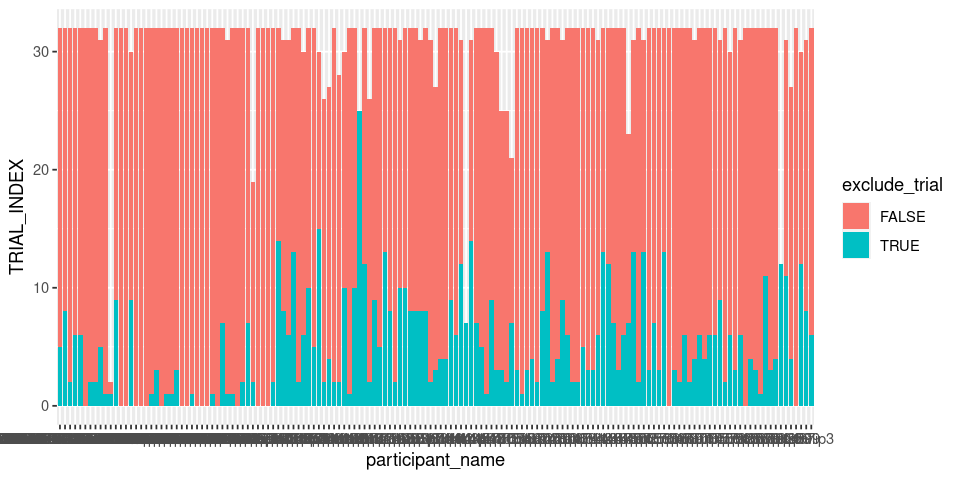

In [26]:
options(repr.plot.width=8, repr.plot.height=4)
ggplot(num_trials_per_subj) + geom_bar(aes(x=participant_name, fill=exclude_trial, 
                                           y=TRIAL_INDEX), stat='identity', position="stack")

# Raw Participant Receptive Scores

In [27]:
ed_df_for_scoring = subset(ed_df, in_study & !exclude_trial)
by_participant = split(ed_df_for_scoring, ed_df_for_scoring$filename)

In [28]:
source('PLEARN_analysis_helper.R')
normalizeMethods = c('none','yoked','preceding')
all_scores = do.call('rbind.fill', lapply(normalizeMethods, function(normalizeMethod){
    do.call('rbind.fill', lapply(by_participant, function(fixbin_df){
        test_participant_receptive_knowledge(fixbin_df, 
            normalizeMethod, end_analysis_window= 1800)
    }))    
}))

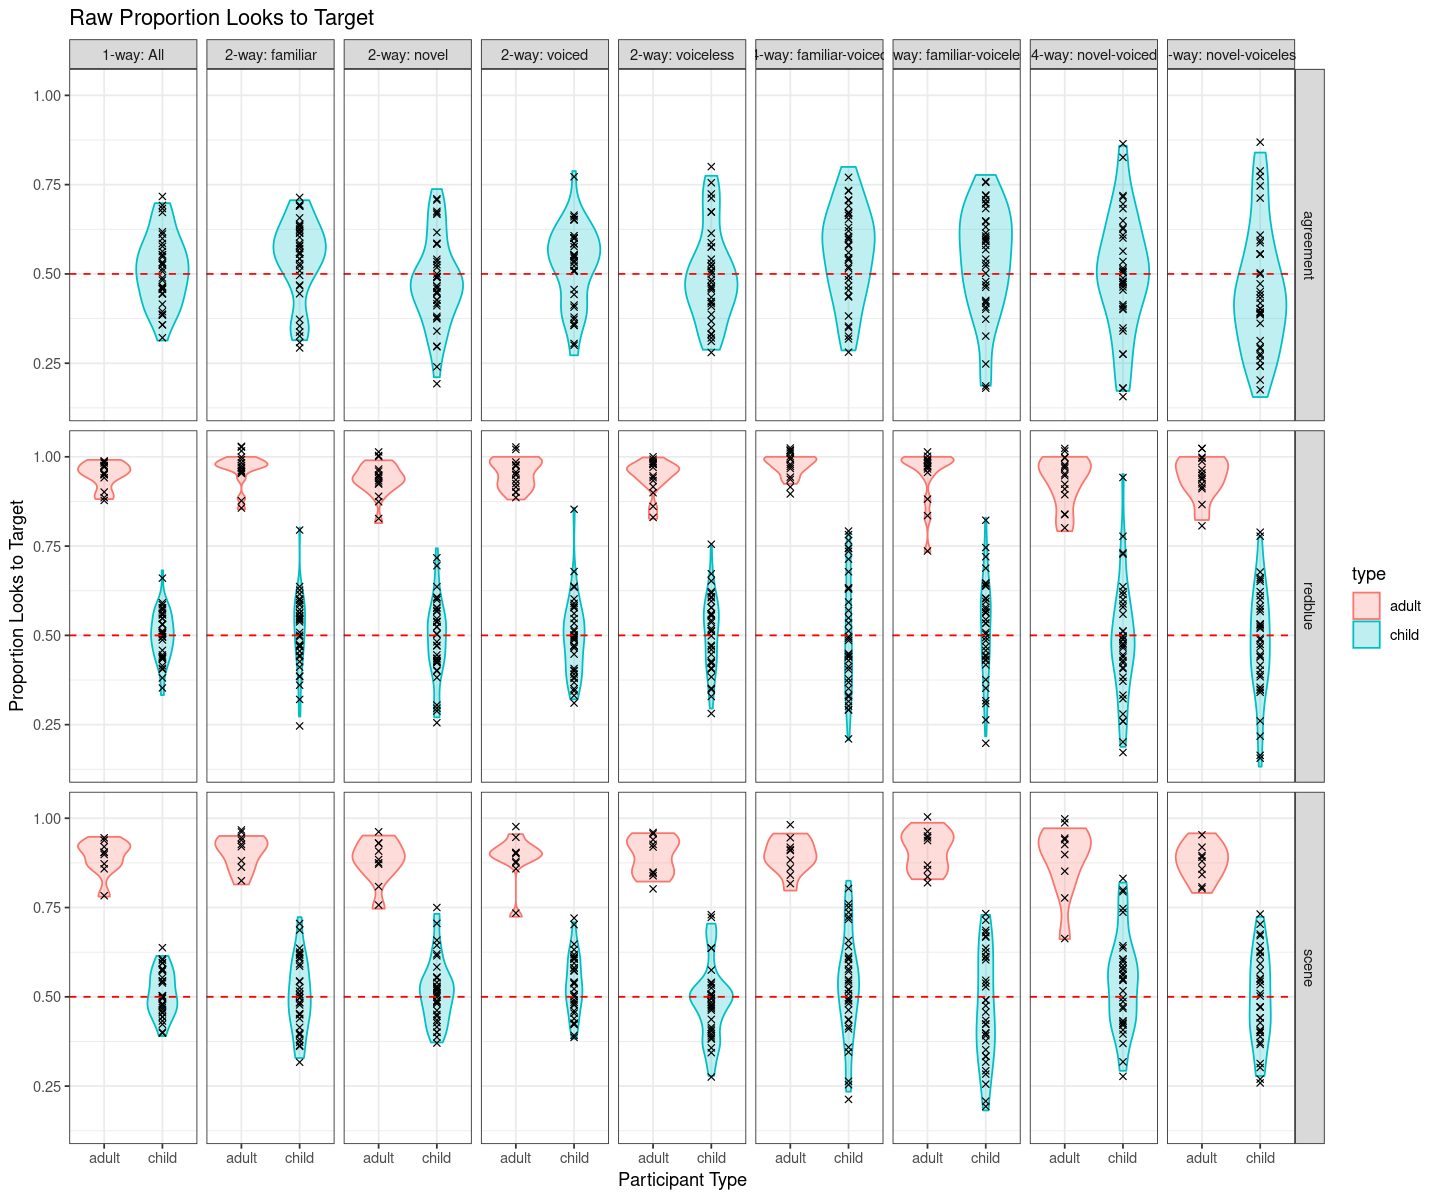

In [29]:
options(repr.plot.width=12, repr.plot.height=10)
ggplot(subset(all_scores, normalizeMethod == 'none')) + geom_violin(
aes(y=prop_looks_to_target, x = type,
colour = type, fill = type), alpha=.25) +
geom_point(aes(x= type, y=prop_looks_to_target), colour ='black',
shape = 4, position=position_jitter(height=.03, width=0)) + facet_grid(
expt_version~partition_name) + theme_bw() + geom_hline(yintercept=.5, 
linetype = 'dashed', colour='red') + ggtitle('Raw Proportion Looks to Target'
) + xlab('Participant Type') + ylab('Proportion Looks to Target') 

In [30]:
names(subject_info)

[1] "participant_name"    "narrow_score"        "broad_score"        
 [4] "id"                  "include_eyetracking" "include_storybook"  
 [7] "filename"            "age_in_days"         "gender"             
[10] "type"                "expt_version"        "group"              
[13] "order"               "comment"             "main_coder"         
[16] "main_validated"      "double_coder"        "double_validated"   
[19] "comments"            "trial_order"         "age_in_months"      
[22] "ran_participant"     "child_in_study"      "fam_pl.x"           
[25] "nov_pl.x"            "total_pl.x"          "fam_pl.y"           
[28] "nov_pl.y"            "total_pl.y"          "in_study"

#  Test for Normality

In [31]:
names(all_scores)

[1] "type"                 "contrast_type"        "prob"                
[4] "prop_looks_to_target" "thresholded"          "partition_name"      
[7] "normalizeMethod"      "participant_name"     "expt_version"

In [32]:
# adults first -- many pairwise tests for this
child_scores = subset(all_scores, normalizeMethod == 'preceding' & type=='child' & 
       contrast_type=='1-way')
# are all normal?

shapiro.test(subset(child_scores, expt_version == 'scene')$prop_looks_to_target)
shapiro.test(subset(child_scores, expt_version == 'redblue')$prop_looks_to_target)
shapiro.test(subset(child_scores, expt_version == 'agreement')$prop_looks_to_target)



	Shapiro-Wilk normality test

data:  subset(child_scores, expt_version == "scene")$prop_looks_to_target
W = 0.98891, p-value = 0.976



	Shapiro-Wilk normality test

data:  subset(child_scores, expt_version == "redblue")$prop_looks_to_target
W = 0.98414, p-value = 0.874



	Shapiro-Wilk normality test

data:  subset(child_scores, expt_version == "agreement")$prop_looks_to_target
W = 0.98602, p-value = 0.9205


# Can We Combine the Eyetracking Experiments? 

In [33]:
expt_versions = c('scene','redblue','agreement')

t_tests_for_combining_eyetracking  = mat.or.vec(length(expt_versions), length(expt_versions))

for (i in 1:length(expt_versions)){
    for (j in c(1:i)){
            t_tests_for_combining_eyetracking[i,j] =  t.test(subset(child_scores, expt_version == expt_versions[i])$prop_looks_to_target,
      subset(child_scores, expt_version == expt_versions[j])$prop_looks_to_target)$p.value
    }
}
    
t_tests_for_combining_eyetracking        

1.0000000,0.0000000,0
0.6133453,1.0000000,0
0.6318922,0.4059546,1


Lower triangle is all ns, so they are not significantly different per unpaired, two-sided t-tests

# Get Descriptive Stats for Each Study

In [34]:
getEyetrackingStudyStats = function(child_scores, expt_vers, tvc){
    # these are subject means? 
    df = subset(child_scores, expt_version == expt_vers)
    #update_texvar_cache(cache, var, value)
    tvc = update_texvar_cache(tvc, paste0(expt_vers,'DiffScoresGt0'), sum(df$prop_looks_to_target > 0))
    tvc = update_texvar_cache(tvc, paste0(expt_vers,'DiffScoresN'),nrow(df))
    tvc = update_texvar_cache(tvc, paste0(expt_vers,'DiffScoresMean'),
                              mean(df$prop_looks_to_target), digits=3)
    tvc = update_texvar_cache(tvc, paste0(expt_vers,'DiffScoresSD'),
                              sd(df$prop_looks_to_target))
    tvc = update_texvar_cache(tvc, paste0(expt_vers,'DiffScoresMin'),
                              min(df$prop_looks_to_target))
    tvc = update_texvar_cache(tvc, paste0(expt_vers,'DiffScoresMax'),
                              max(df$prop_looks_to_target))
    t_test = t.test(df$prop_looks_to_target, mu=0)
    tvc = update_texvar_cache(tvc, paste0(expt_vers,'DiffScoresTStatisistic'),
                             t_test$statistic)
    tvc = update_texvar_cache(tvc, paste0(expt_vers,'DiffScoresTdf'),
                             t_test$parameter)
    tvc = update_texvar_cache(tvc, paste0(expt_vers,'DiffScoresPvalue'),
                             t_test$p.value)
    return(tvc)
}

In [35]:
tvc = getEyetrackingStudyStats(child_scores, 'scene',tvc)
tvc = getEyetrackingStudyStats(child_scores, 'redblue',tvc)
tvc = getEyetrackingStudyStats(child_scores, 'agreement',tvc)

# Response Time When Looking at Distractor

In [36]:
metadata_cols = c('animacystatus', 'background_context','distractorimage',
'distractorloc', 'expt_index', 'full_carrier', 'novel_id', 'novelcolor',
'novelty', 'order', 'pl_carrier', 'pl_form', 'pl_punct', 'pl_sentence',
'pl_wav_index', 'practice', 's_carrier', 's_form', 's_punct',
's_sentence', 's_wav_index', 'simple_pl_stim', 'simple_s_stim', 'target',
'targetimage', 'targetloc', 'targetside', 'test_index', 'trial', 'voicing', 'vowel_carrier',
'RECORDING_SESSION_LABEL')

In [37]:
# source('PLEARN_analysis_helper.R')
# test_df = do.call('rbind',lapply(by_participant, function(fixreport){
#     print(unique(fixreport$filename))
#     getParticipantRTs(380, fixreport, label_colname="CURRENT_FIX_INTEREST_AREA_LABEL", metadata_cols, include_non_roi_label=T)
# })) 

# Per-Subject Preference Before Disambiguation

In [38]:
beforeafter_disambig_df = subset(ed_df, 
    CURRENT_FIX_INTEREST_AREA_LABEL %in% c('TARGET','DISTRACTOR')) 
beforeafter_disambig_df$looking_at_plural = 0
beforeafter_disambig_df$looking_at_plural[
    beforeafter_disambig_df$CURRENT_FIX_INTEREST_AREA_LABEL == 'TARGET' & 
    beforeafter_disambig_df$target == 'pl'] = 1
beforeafter_disambig_df$looking_at_plural[
    beforeafter_disambig_df$CURRENT_FIX_INTEREST_AREA_LABEL == 'DISTRACTOR' & 
    beforeafter_disambig_df$target == 's'] = 1
beforeafter_disambig_df$beforeafter = 'After Disambiguation'
beforeafter_disambig_df$beforeafter[beforeafter_disambig_df$Time < 367] = 'Before Disambiguation'
beforeafter_disambig_preference = aggregate(looking_at_plural ~ participant_name +
    type + beforeafter + TRIAL_INDEX, 
    beforeafter_disambig_df, mean)

beforeafter_disambig_by_subject = do.call(data.frame, aggregate(looking_at_plural ~ participant_name + type +  beforeafter, beforeafter_disambig_preference, FUN = function(x){c(mean=mean(x), sd = sd(x))}))                                       


In [39]:
beforeafter_disambig_by_subject$looking_at_plural_low = 
    beforeafter_disambig_by_subject$looking_at_plural.mean - beforeafter_disambig_by_subject$looking_at_plural.sd
beforeafter_disambig_by_subject$looking_at_plural_high = 
    beforeafter_disambig_by_subject$looking_at_plural.mean + beforeafter_disambig_by_subject$looking_at_plural.sd

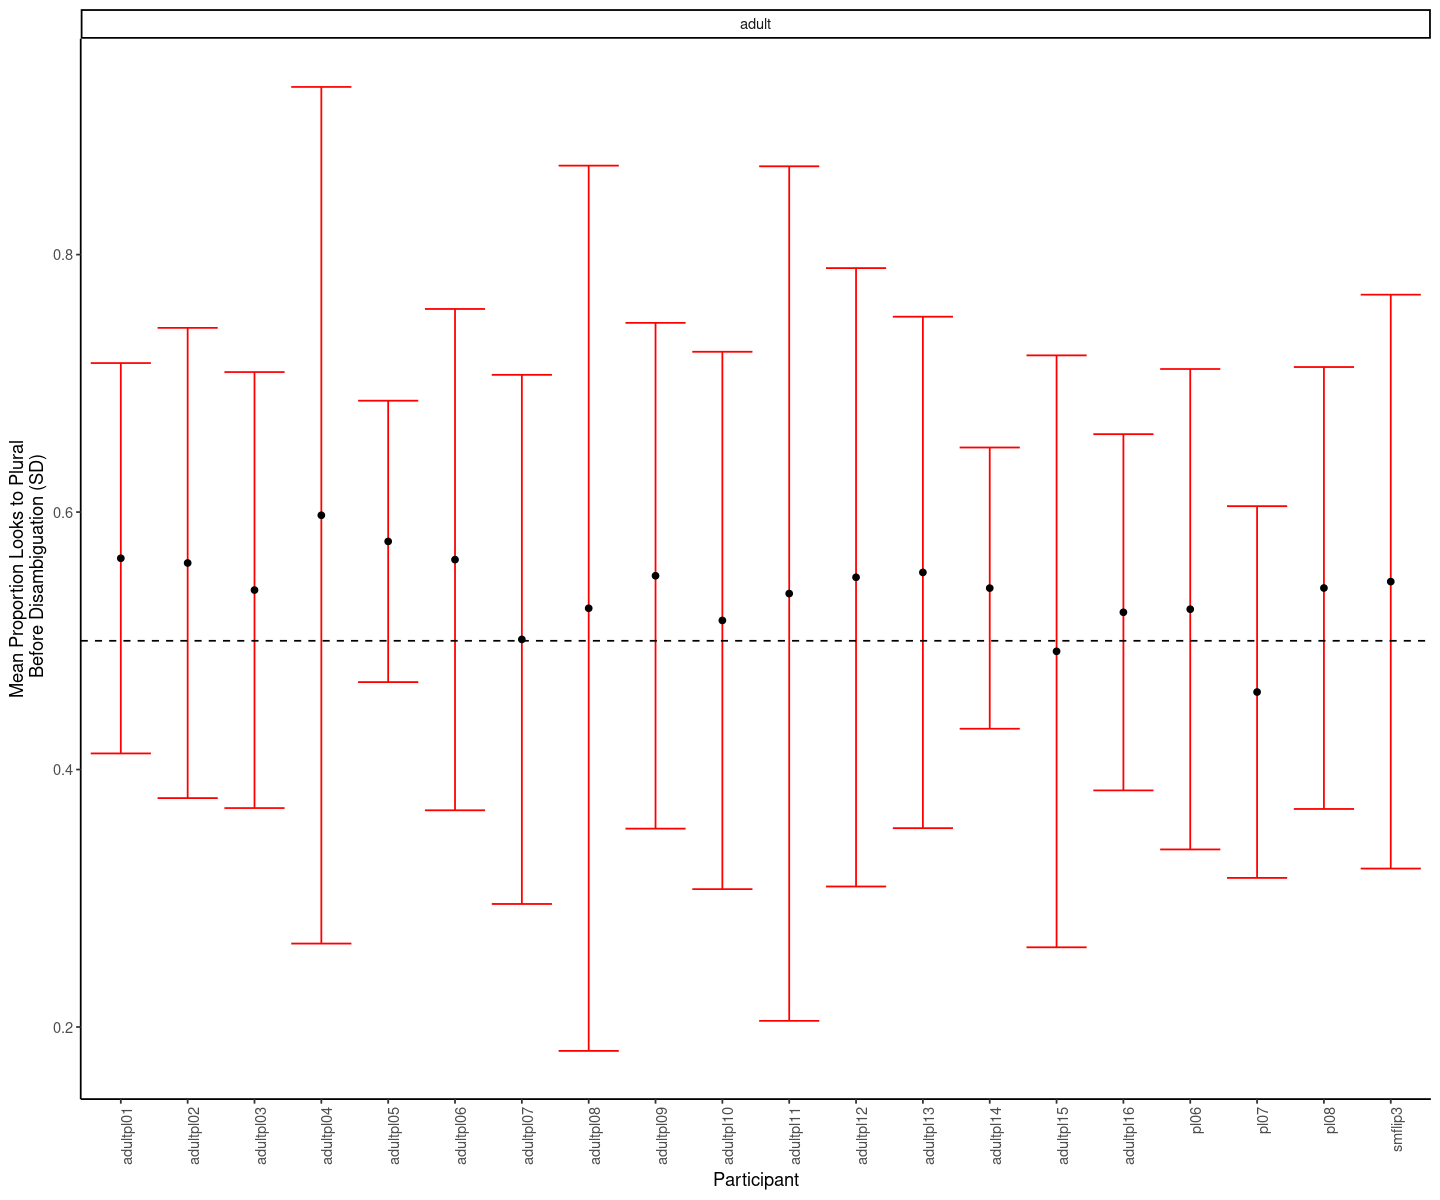

In [40]:
#options(repr.plot.width=4, repr.plot.height=4)
ggplot(subset(beforeafter_disambig_by_subject, beforeafter == "Before Disambiguation" &
type == 'adult')) + geom_errorbar(aes(x=participant_name, ymin= looking_at_plural_low,
 ymax= looking_at_plural_high), color='red') + geom_point(aes(x=participant_name, 
y=looking_at_plural.mean)) + theme_classic() + geom_hline(yintercept=.5, linetype = 'dashed'
) + xlab('Participant') + ylab('Mean Proportion Looks to Plural\n Before Disambiguation (SD)'
) + theme(axis.text.x = element_text(angle = 90, hjust = 1)) + facet_wrap(~type)

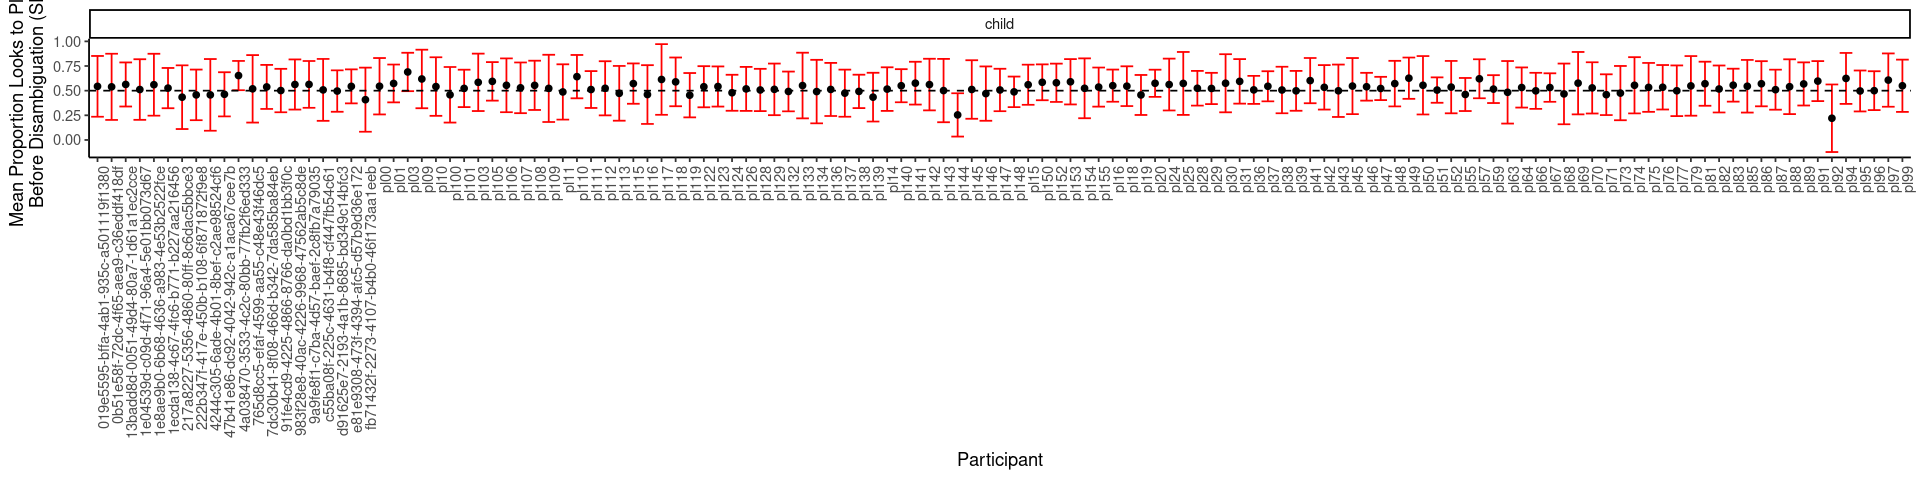

In [41]:
options(repr.plot.width=16, repr.plot.height=4)
ggplot(subset(beforeafter_disambig_by_subject, beforeafter == "Before Disambiguation" &
type == 'child')) + geom_errorbar(aes(x=participant_name, ymin= looking_at_plural_low,
 ymax= looking_at_plural_high), color='red') + geom_point(aes(x=participant_name, 
y=looking_at_plural.mean)) + theme_classic() + geom_hline(yintercept=.5, linetype = 'dashed'
) + xlab('Participant') + ylab('Mean Proportion Looks to Plural\n Before Disambiguation (SD)'
) + theme(axis.text.x = element_text(angle = 90, hjust = 1)) + facet_wrap(~type)

# Write Out TexVars

In [42]:
writeout_texvar_cache(tvc, 'texvars/plearn_analysis_03.tex',appendDate=T)

# Save the R objects for loading in the other notebooks

In [43]:
saveRDS(ed_df, file='intermediate_data/eyetracking_fixations_df.RData')
saveRDS(all_scores, file='intermediate_data/all_scores.RData')